In [1]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.patches import Patch
from PIL import Image
import colormaps as cmaps
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

os.chdir(r'D:\pku\UES\UrbanHeatIsland\Data\202501_allpixel')

In [ ]:
#merge GRs scenarios in each country
if 0 :
    df_all = pd.DataFrame()
    dfs = os.listdir('./GRs')
    for name in dfs:
        if name.endswith('.csv'):
            df = pd.read_csv('./GRs/'+name)
            df_all = pd.concat([df_all, df], ignore_index=True)
    df_all.to_csv('./GRs_all_merged.csv', index=False)
    df_all_simple = df_all[['ADM0_CODE','ADM0_NAME','ADM1_CODE','ADM1_NAME','ADM2_CODE','ADM2_NAME','low_cc','low_cc_change','medium_cc','medium_cc_change','high_cc','high_cc_change','.geo']]
    #remove duplicate
    df_all_simple.drop_duplicates(subset=['ADM2_CODE'], keep='first', inplace=True)
    geom = [shape(eval(i)) for i in df_all_simple['.geo']]
    df_all_simple = gpd.GeoDataFrame(df_all_simple,geometry=geom)
    df_all_simple['geometry'] = df_all_simple['geometry'].centroid
    df_all_simple.to_file(r'.\df_GRs_all_simple.geojson', driver="GeoJSON")

In [ ]:
#check null roof simulations
df_all_simple = gpd.read_file(r'.\df_GRs_all_simple.geojson')
df_all_simple.isnull().sum()

In [ ]:
#connect to model4 pars
df_model4 = pd.read_csv('./pars_quality_final_ava_model4_allpixel_watermask0.csv')
df_scenarios = pd.merge(df_all_simple, 
                        df_model4[['ADM2CODE', 'model', 'coefs', '2.5 %', '97.5 %', 'estimate','par_p_value', 'rmse', 'r2', 'p_value']],
                        left_on='ADM2_CODE', right_on='ADM2CODE' ,how='right')
#remove null scenarios
df_scenarios_ava = df_scenarios.dropna(subset=['low_cc'], inplace=False)
df_scenarios_ava.columns

In [ ]:
#cooling effects
df_cooling = pd.DataFrame()
df_cooling['ADM2_CODE'] = df_scenarios_ava['ADM2_CODE']
df_cooling['model'] = df_scenarios_ava['model']
df_cooling['low_cc_cooling'] = df_scenarios_ava['low_cc_change']*df_scenarios_ava['estimate']
df_cooling['mid_cc_cooling'] = df_scenarios_ava['medium_cc_change']*df_scenarios_ava['estimate']
df_cooling['hig_cc_cooling'] = df_scenarios_ava['high_cc_change']*df_scenarios_ava['estimate']

df_cooling['uncertainty_ratio'] = 0.5 * (df_scenarios_ava['2.5 %'] - df_scenarios_ava['97.5 %']) / df_scenarios_ava['estimate']

In [5]:
df_cooling = gpd.GeoDataFrame(df_cooling,geometry=df_scenarios_ava['geometry'])

In [ ]:
#edit urban props
'''
1 Taiwan was calculated separately
2 some cities 65060, 15524, 3994, 14263,3887,10168,33375
were found with zero roof area but tiny cooling effect due to
the cooling simulation was calculated at 250 resolution,
that some of the pixels were overlapped with the smod urban layer,
but the calculation of roof area is at 2.5 resolution,
lead to no overlapped roofs, here we keep the cooling effect
'''
if 0:
    df_urban_stat = pd.read_csv('./Urban_stat_lst_vc_rural_urban.csv')
    #drop duplicate
    df_urban_stat = df_urban_stat.drop_duplicates(subset=['ADM2_CODE'],keep='first')
    #merge cold and polar
    # df_urban_stat.loc[df_urban_stat['koppen_climate_remap'].isin([4,5]), 'koppen_climate_remap'] = 4

    #lst bins
    day_temp_bins = [-np.inf,28,32,36,np.inf]
    night_temp_bins = [-np.inf,22,24,28,np.inf]
    df_urban_stat['LST_day_mean_bins'] = pd.cut(df_urban_stat['LST_urban_day_mean']-273.15,bins=day_temp_bins,labels=['<28','28~32','32~36','>36'])
    df_urban_stat['LST_night_mean_bins'] = pd.cut(df_urban_stat['LST_urban_night_mean']-273.15,bins=night_temp_bins,labels=['<22','22~24','24~28','>28'])

    #new roof area 
    df_roofarea_glob = pd.read_csv('./Urban_stat_lst_roofarea_global_exchina.csv')
    df_roofarea_chn = pd.read_csv('./Urban_stat_lst_roofarea_chn.csv')
    df_roofarea_chn_taiwan = pd.read_csv('./Urban_stat_lst_roofarea_chn_taiwan.csv')
    df_roofarea_glob2 = df_roofarea_glob.loc[df_roofarea_glob['ADM0_NAME']!='China',:]
    df_roofarea_glob2 = pd.concat([df_roofarea_glob2,df_roofarea_chn,df_roofarea_chn_taiwan])
    df_urban_stat2 = pd.merge(df_urban_stat, df_roofarea_glob2[['roof_area','ADM2_CODE']], on=['ADM2_CODE'], how='left')
    df_urban_stat2.to_csv('./Urban_stat_lst_vc_rural_urban_clean.csv', index=False)

In [6]:
# assign continent manually in excel
df_urban_stat = pd.read_csv('./Urban_stat_lst_vc_rural_urban_clean.csv')
df_urban_stat.drop_duplicates(subset=['ADM2_CODE'],inplace=True)

# vc bins
vc_bins = [0,20,40,60,80,100]
df_urban_stat['vc_mean_bins'] = pd.cut(df_urban_stat['vc_mean'],bins=vc_bins,labels=['0~20','20~40','40~60','60~80','80~100'])

# roof area bins
roof_bins = [0,1e5,1e6,1e7,1e8,np.inf]
df_urban_stat['roof_area_bins'] = pd.cut(df_urban_stat['roof_area'],bins=roof_bins,labels=['0~1e5','1e5~1e6','1e6~1e7','1e7~1e8','>1e8'])

# roof area/urban area bins
df_urban_stat['roof_ratio'] = df_urban_stat['roof_area']/df_urban_stat['urban_area']

rr_bins = [0,0.2,0.4,0.6,0.8,1]
df_urban_stat['roof_ratio_bins'] = pd.cut(df_urban_stat['roof_ratio'],bins=rr_bins,labels=['0~20','20~40','40~60','60~80','80~100'])

#only present results with valid properties for consistency
df_cooling_stat = pd.merge(df_cooling,df_urban_stat[['vc_mean','vc_mean_bins',
                                                     'urban_area','roof_area','roof_area_bins','roof_ratio','roof_ratio_bins',
                                                     'population_count','Continent',
                                                     'LST_urban_day_mean','LST_urban_night_mean','LST_day_mean_bins','LST_night_mean_bins',
                                                     'LST_rural_day_mean','LST_rural_night_mean',
                                                     'ADM2_CODE','ADM0_CODE']],on=['ADM2_CODE'],how='left')

#remove several outliers (roof_area = inf or >1, because of the projection or layer distortion)
df_cooling_stat = df_cooling_stat.loc[(~np.isinf(df_cooling_stat['roof_ratio'])) & (df_cooling_stat['roof_ratio'] < 1),:]
#drop na and inf 
df_cooling_stat = df_cooling_stat.dropna()

In [ ]:
#statistics

#1 avaliable cities
print('all',df_cooling_stat['ADM2_CODE'].unique().shape[0])
print('day',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day','ADM2_CODE'].count())
print('night',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night','ADM2_CODE'].count())
df_cooling_count = df_cooling_stat.groupby('ADM2_CODE').count().reset_index()
df_cooling_count_2_code = df_cooling_count.loc[df_cooling_count['model'] == 2,'ADM2_CODE']
print('paired',len(df_cooling_count_2_code))
print('------')
#2 global cooling potential
print('day cooling potential\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].mean().round(2))
print('day cooling potential sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].std().round(2))
print('night cooling potential\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].mean().round(2))
print('night cooling potential sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].std().round(2))
print('------')
#3 cooling uncertainties
print('day cooling uncertainty\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['uncertainty_ratio']].mean().round(2))
print('day cooling uncertainty sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['uncertainty_ratio']].std().round(2))
print('night cooling uncertainty\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['uncertainty_ratio']].mean().round(2))
print('night cooling uncertainty sd\n',df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['uncertainty_ratio']].std().round(2))

In [8]:
# bins = [-np.inf, -4, -2, -1, -0.5, 0]
# labels = ['>4.00','2.00~4.00','1.00~2.00','0.50~1.00','0.00~0.50']

bins = [-np.inf, -2, -1, -0.5, -0.25, 0]
labels = ['>2.00','1.00~2.00','0.50~1.00','0.25~0.50','0.00~0.25']
df_cooling_stat['low_cc_cooling_class'] = pd.cut(df_cooling_stat['low_cc_cooling'], bins=bins, labels=labels)
df_cooling_stat['mid_cc_cooling_class'] = pd.cut(df_cooling_stat['mid_cc_cooling'], bins=bins, labels=labels)
df_cooling_stat['hig_cc_cooling_class'] = pd.cut(df_cooling_stat['hig_cc_cooling'], bins=bins, labels=labels)
# df_cooling['low_cc_uncertainty_class'] = pd.cut(df_cooling['low_cc_uncertainty'], bins=bins, labels=labels)
# df_cooling['mid_cc_uncertainty_class'] = pd.cut(df_cooling['mid_cc_uncertainty'], bins=bins, labels=labels)
# df_cooling['hig_cc_uncertainty_class'] = pd.cut(df_cooling['hig_cc_uncertainty'], bins=bins, labels=labels)

In [ ]:
df_cooling_stat.columns

In [9]:
#uncertainty ratio
bins = [0,0.2,0.4,0.6,np.inf]
labels = ['0.00~0.20','0.20~0.40','0.40~0.60','>0.60']
df_cooling_stat['uncertainty_ratio_class'] = pd.cut(df_cooling_stat['uncertainty_ratio'], bins=bins, labels=labels)

In [ ]:
df_cooling_stat.loc[df_cooling_stat['model'] == "model4_day",'uncertainty_ratio_class'].describe()

In [ ]:
df_cooling_stat.loc[df_cooling_stat['model'] == "model4_night",'uncertainty_ratio_class'].describe()

In [ ]:
df_cooling_stat['uncertainty_ratio'].describe()

In [15]:
# count cities in each class
def count_cities_in_class(df, column=['low_cc_cooling_class', 'mid_cc_cooling_class', 'hig_cc_cooling_class']):

    column_value_counts = {}

    for col in column:
        column_value_counts[col] = df[col].value_counts().sort_index()

    df_column_value_counts = pd.DataFrame(column_value_counts)
    return df_column_value_counts

def plot_bar_with_labels(ax, data, column, colors, ylabel='Number of cities',xlabel= '',ftsize=2, ylabel_loc = 'bottom',ylabel_pad=0.5,height_str = ' <1'):
    bars = ax.bar(data.index, data[column], color=colors,edgecolor='dimgray',linewidth=0.2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for bar in bars:
        height = bar.get_height()
        if height < 1:
            height_str = height_str
        else:
            height_str = ' '+str(int(height))
        ax.text(bar.get_x() + bar.get_width() / 2, height, height_str,
                ha='center', va='bottom', rotation=90, fontsize=ftsize)
    
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)

    ax.set_ylabel(ylabel, fontsize=ftsize,labelpad=ylabel_pad, loc=ylabel_loc)
    ax.set_xlabel(xlabel, fontsize=ftsize,labelpad=ylabel_pad)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('none')

In [44]:
df_cooling_day = df_cooling_stat[df_cooling_stat['model'] == 'model4_day']
df_cooling_night = df_cooling_stat[df_cooling_stat['model'] == 'model4_night']
df_cooling_day_stat = count_cities_in_class(df_cooling_day).iloc[::-1]
df_cooling_night_stat = count_cities_in_class(df_cooling_night).iloc[::-1]
df_cooling_day_stat_uncertainty = count_cities_in_class(df_cooling_day, column=['uncertainty_ratio_class'])
df_cooling_night_stat_uncertainty = count_cities_in_class(df_cooling_night, column=['uncertainty_ratio_class'])


In [ ]:
#influence on suhi
df_cooling_day.loc[:,'Day_suhi'] = df_cooling_day.loc[:,'LST_urban_day_mean'] - df_cooling_day.loc[:,'LST_rural_day_mean']
df_cooling_night.loc[:,'Night_suhi'] = df_cooling_night.loc[:,'LST_urban_night_mean'] - df_cooling_night.loc[:,'LST_rural_night_mean']

df_cooling_day.loc[:,'low_suhi_change'] = -df_cooling_day.loc[:,'low_cc_cooling'] / df_cooling_day.loc[:,'Day_suhi']
df_cooling_day.loc[:,'mid_suhi_change'] = -df_cooling_day.loc[:,'mid_cc_cooling'] / df_cooling_day.loc[:,'Day_suhi']
df_cooling_day.loc[:,'hig_suhi_change'] = -df_cooling_day.loc[:,'hig_cc_cooling'] / df_cooling_day.loc[:,'Day_suhi']
df_cooling_night.loc[:,'low_suhi_change'] = -df_cooling_night.loc[:,'low_cc_cooling'] / df_cooling_night.loc[:,'Night_suhi']
df_cooling_night.loc[:,'mid_suhi_change'] = -df_cooling_night.loc[:,'mid_cc_cooling'] / df_cooling_night.loc[:,'Night_suhi']
df_cooling_night.loc[:,'hig_suhi_change'] = -df_cooling_night.loc[:,'hig_cc_cooling'] / df_cooling_night.loc[:,'Night_suhi']

#filter SUHII >1 
df_cooling_day.loc[df_cooling_day.loc[:,'Day_suhi']<1,['low_suhi_change','mid_suhi_change','hig_suhi_change']] = np.nan
df_cooling_night.loc[df_cooling_night.loc[:,'Night_suhi']<1,['low_suhi_change','mid_suhi_change','hig_suhi_change']] = np.nan

#into bins
bins = [0,0.2,0.4,0.6,0.8,np.inf]
labels = ['0.00~0.20','0.20~0.40','0.40~0.60','0.60~0.80','>0.80']
df_cooling_day.loc[:,'low_suhi_change_class'] = pd.cut(df_cooling_day.loc[:,'low_suhi_change'], bins=bins, labels=labels)
df_cooling_day.loc[:,'mid_suhi_change_class'] = pd.cut(df_cooling_day.loc[:,'mid_suhi_change'], bins=bins, labels=labels)
df_cooling_day.loc[:,'hig_suhi_change_class'] = pd.cut(df_cooling_day.loc[:,'hig_suhi_change'], bins=bins, labels=labels)
df_cooling_night.loc[:,'low_suhi_change_class'] = pd.cut(df_cooling_night.loc[:,'low_suhi_change'], bins=bins, labels=labels)
df_cooling_night.loc[:,'mid_suhi_change_class'] = pd.cut(df_cooling_night.loc[:,'mid_suhi_change'], bins=bins, labels=labels)
df_cooling_night.loc[:,'hig_suhi_change_class'] = pd.cut(df_cooling_night.loc[:,'hig_suhi_change'], bins=bins, labels=labels)

In [ ]:
print("day suhi change",df_cooling_day.loc[:,['low_suhi_change','mid_suhi_change','hig_suhi_change']].describe())
print("night suhi change",df_cooling_night.loc[:,['low_suhi_change','mid_suhi_change','hig_suhi_change']].describe())

In [53]:
df_shui_change_day_stat = count_cities_in_class(df_cooling_day, column=['low_suhi_change_class','mid_suhi_change_class','hig_suhi_change_class'])
df_suhi_change_night_stat = count_cities_in_class(df_cooling_night, column=['low_suhi_change_class','mid_suhi_change_class','hig_suhi_change_class'])

In [ ]:
plt.hist(df_cooling_day['low_suhi_change'],bins=np.linspace(0, 1, 6),alpha = 0.6)
plt.hist(df_cooling_day['mid_suhi_change'],bins=np.linspace(0, 1, 6),alpha = 0.6)
plt.hist(df_cooling_day['hig_suhi_change'],bins=np.linspace(0, 1, 6),alpha = 0.6)

In [ ]:
df_cooling_day['low_cc_cooling_class'].unique()

In [ ]:
print('cities without urban stat',len(df_cooling),len(df_cooling_stat))

In [ ]:
#color map and base map
cmp1 = plt.get_cmap('YlGnBu_r') #YlGnBu_r winter
colors1 = cmp1(np.linspace(0, 1, 7))[1:6]
cmp1 = mpl.colors.ListedColormap(colors1)

cmp2 = plt.get_cmap('Set3')
colors2 = cmp2(np.linspace(0, 1, 12))[0:4]
cmp2 = mpl.colors.ListedColormap(colors2)

In [ ]:
#figure 1 daytime cooling effects
#plot
fig,axs = plt.subplots(3,2,figsize=(9,7),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['low_cc_cooling_class','mid_cc_cooling_class','hig_cc_cooling_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_day.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_day_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    #remove bounds
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(3):
    ax_i = axs[i,1]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_night.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_night_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-5, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp1.reversed(), norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[-4.5, -3.5, -2.5, -1.5, -0.5],labels=['0.00~0.25', '0.25~0.50','0.50~1.00','1.00~2.00','>2.00'], fontsize=12)
#set title
cbar.set_label('Cooling potential (°C)',fontsize=12)


#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

#insert icons
# height_list = [0.13,0.38,0.65]
# scenario_names = ['high','mid','low']
# for i in range(3):
#     height = height_list[i]
#     icon_ax = fig.add_axes([0.06, height, 0.075, 0.075])
#     icon_image = Image.open(r'D:\pku\UES\UrbanHeatIsland\Manuscripts\figs\scenario_'+scenario_names[i]+'.png')
#     icon_ax.imshow(icon_image, aspect='equal',)
#     icon_ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
# plt.savefig('./Figs3/fig2.png', dpi=300, bbox_inches='tight')
# plt.savefig('./Figs3/fig2.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
#figure s1 daytime cooling effects uncertainty ratio
#plot
fig,axs = plt.subplots(1,2,figsize=(9,3),dpi=300,subplot_kw={'projection': ccrs.Robinson()})

axs[0].set_global()
axs[0].add_feature(cfeature.LAND, facecolor="silver")
axs[0].set_extent([-180, 180, -60, 90])
cax = df_cooling_day.plot(column='uncertainty_ratio_class', ax=axs[0], cmap=cmp2, legend=False,
             edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
             legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
inset_ax = inset_axes(axs[0], width="20%", height="20%", 
                      bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=axs[0].transAxes)
plot_bar_with_labels(inset_ax, df_cooling_day_stat_uncertainty, 'uncertainty_ratio_class', colors2,xlabel='',ftsize=7)

axs[1].set_global()
axs[1].add_feature(cfeature.LAND, facecolor="silver")
axs[1].set_extent([-180, 180, -60, 90])
cax = df_cooling_night.plot(column='uncertainty_ratio_class', ax=axs[1], cmap=cmp2, legend=False,
             edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
             legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
inset_ax = inset_axes(axs[1], width="20%", height="20%", 
                      bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=axs[1].transAxes)
plot_bar_with_labels(inset_ax, df_cooling_night_stat_uncertainty, 'uncertainty_ratio_class', colors2,xlabel='',ftsize=7)


axs[0].set_title('Day', loc='center', fontsize=12)
axs[1].set_title('Night', loc='center', fontsize=12)

norm = mpl.colors.Normalize(vmin=0, 
                            vmax=0.8)
sm = plt.cm.ScalarMappable(cmap=cmp2, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[0.1,0.3,0.5,0.7],labels=['0.00~0.20','0.20~0.40','0.40~0.60','>0.60'], fontsize=12)
#set title
cbar.set_label('Cooling potential uncertainty (°C)',fontsize=12)

#add labels
labels = ['a', 'b']
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# plt.savefig('./Figs3/figs1.png', dpi=300, bbox_inches='tight')
# plt.savefig('./Figs3/figs1.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
#figure changes on shui
#plot
fig,axs = plt.subplots(3,2,figsize=(9,7),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['low_suhi_change_class','mid_suhi_change_class','hig_suhi_change_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_day.plot(column=col_name, ax=ax_i, cmap=cmp1.reversed(), legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_shui_change_day_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    #remove bounds
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(3):
    ax_i = axs[i,1]
    col_name = plot_columns[i]
    ax_i.set_extent([-180, 180, -60, 90])
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    cax = df_cooling_night.plot(column=col_name, ax=ax_i, cmap=cmp1.reversed(), legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_suhi_change_night_stat, col_name, colors1[::-1],xlabel='',ftsize=7,height_str=' 0')
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-5, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp1.reversed(), norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[-4.5, -3.5, -2.5, -1.5, -0.5],labels=["0~20","20~40","40~60","60~80",">80"], fontsize=12)
#set title
cbar.set_label('SUHII reduction (%)',fontsize=12)


#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

#insert icons
# height_list = [0.13,0.38,0.65]
# scenario_names = ['high','mid','low']
# for i in range(3):
#     height = height_list[i]
#     icon_ax = fig.add_axes([0.06, height, 0.075, 0.075])
#     icon_image = Image.open(r'D:\pku\UES\UrbanHeatIsland\Manuscripts\figs\scenario_'+scenario_names[i]+'.png')
#     icon_ax.imshow(icon_image, aspect='equal',)
#     icon_ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.savefig('./Figs3/fig_suhi.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs3/fig_suhi.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
#influence on suhi
df_cooling_stat.columns

In [63]:
#figure 2 statistics
df_cooling_stat['low_cooling_population'] = df_cooling_stat['population_count'] * df_cooling_stat['low_cc_cooling']
df_cooling_stat['mid_cooling_population'] = df_cooling_stat['population_count'] * df_cooling_stat['mid_cc_cooling']
df_cooling_stat['hig_cooling_population'] = df_cooling_stat['population_count'] * df_cooling_stat['hig_cc_cooling']

In [64]:
df_cooling_stat_continent_longer = df_cooling_stat[['ADM2_CODE','model','Continent','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','Continent','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_continent_longer['effects'] = abs(df_cooling_stat_continent_longer['effects'])

df_cooling_stat_day_background_longer = df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',
                                                            ['ADM2_CODE','model','LST_day_mean_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','LST_day_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_day_background_longer['effects'] = abs(df_cooling_stat_day_background_longer['effects'])
df_cooling_stat_night_background_longer = df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',
                                                              ['ADM2_CODE','model','LST_night_mean_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','LST_night_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_night_background_longer['effects'] = abs(df_cooling_stat_night_background_longer['effects'])

df_cooling_stat_vc_longer = df_cooling_stat.loc[:,['ADM2_CODE','model','vc_mean_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','vc_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_roofarea_longer = df_cooling_stat.loc[:,['ADM2_CODE','model','roof_area_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','roof_area_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_rr_longer = df_cooling_stat.loc[:,['ADM2_CODE','model','roof_ratio_bins','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','roof_ratio_bins','model'],var_name='cooling_type',value_name='effects')
#abs
df_cooling_stat_vc_longer['effects'] = abs(df_cooling_stat_vc_longer['effects'])
df_cooling_stat_roofarea_longer['effects'] = abs(df_cooling_stat_roofarea_longer['effects'])
df_cooling_stat_rr_longer['effects'] = abs(df_cooling_stat_rr_longer['effects'])

In [65]:
df_cooling_stat_continent_pop_longer = df_cooling_stat[['ADM2_CODE','model','Continent','low_cooling_population','mid_cooling_population','hig_cooling_population']].melt(
    id_vars=['ADM2_CODE','Continent','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_continent_pop_longer['effects'] = abs(df_cooling_stat_continent_pop_longer['effects'])*(1e-5)

df_cooling_stat_day_background_pop_longer = df_cooling_stat[['ADM2_CODE','model','LST_day_mean_bins','low_cooling_population','mid_cooling_population','hig_cooling_population']].melt(
    id_vars=['ADM2_CODE','LST_day_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_day_background_pop_longer['effects'] = abs(df_cooling_stat_day_background_pop_longer['effects'])*(1e-5)
df_cooling_stat_night_background_pop_longer = df_cooling_stat[['ADM2_CODE','model','LST_night_mean_bins','low_cooling_population','mid_cooling_population','hig_cooling_population']].melt(
    id_vars=['ADM2_CODE','LST_night_mean_bins','model'],var_name='cooling_type',value_name='effects')
df_cooling_stat_night_background_pop_longer['effects'] = abs(df_cooling_stat_night_background_pop_longer['effects'])*(1e-5)

In [66]:
#set colors
edge_colors = plt.get_cmap('BuGn')
edge_colors = edge_colors(np.linspace(0, 1, 4))
edge_colors = [edge_colors[i] for i in [1,2,3]]
edge_colors = plt.get_cmap('Set2')
edge_colors = edge_colors(np.linspace(0, 1, 8))[0:3]
white_colors = ['white','white','white']

continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
climate_order = [1,2,3,4]
day_bg_order = ['<28','28~32','32~36','>36']
night_bg_order = ['<22','22~24','24~28','>28']
vc_order = ['0~20','20~40','40~60','60~80','80~100']
roof_area_order = ['0~1e5','1e5~1e6','1e6~1e7','1e7~1e8','>1e8']
rr_order = ['0.0~0.2','0.2~0.4','0.4~0.6','0.6~0.8','0.8~1.0']

In [ ]:
#LST    
print('LST-day',df_cooling_stat_day_background_longer[df_cooling_stat_day_background_longer['model'] == 'model4_day'].groupby(['LST_day_mean_bins','cooling_type']).count())
print('LST-night',df_cooling_stat_night_background_longer[df_cooling_stat_night_background_longer['model'] == 'model4_night'].groupby(['LST_night_mean_bins','cooling_type']).count())

print('vc_bins_stat-day',df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_day'].groupby(['vc_mean_bins','cooling_type']).count())
print('vc_bins_stat-night',df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_night'].groupby(['vc_mean_bins','cooling_type']).count())

print('roof_ratio_bins_stat-day',df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_day'].groupby(['roof_ratio_bins','cooling_type']).count())
print('roof_ratio_bins_stat-night',df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_night'].groupby(['roof_ratio_bins','cooling_type']).count())

In [ ]:
df_cooling_stat_rr_longer.loc[(df_cooling_stat_rr_longer['model'] == 'model4_day') & (df_cooling_stat_rr_longer['roof_ratio_bins'] == '80~100'),:]

In [ ]:
#figure 2 boxplot roof ratio group by bins

#set colors
# edge_colors = plt.get_cmap('GnBu')
# edge_colors = edge_colors(np.linspace(0, 1, 8))[0:5]
edge_colors = colors1[::-1]

bg_colors = plt.get_cmap('BuGn')
bg_colors = bg_colors(np.linspace(0, 1, 4))
bg_colors = [bg_colors[i] for i in [1,2,3]]

continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
climate_order = [1,2,3,4]
day_bg_order = ['<28','28~32','32~36','>36']
night_bg_order = ['<22','22~24','24~28','>28']
vc_order = ['0~20','20~40','40~60','60~80','80~100']
roof_area_order = ['0~1e5','1e5~1e6','1e6~1e7','1e7~1e8','>1e8']
rr_order = ['0~20','20~40','40~60','60~80','80~100']

fig,axs = plt.subplots(2,3,figsize=(9,7),dpi=300)

sns.boxplot(data=df_cooling_stat_day_background_longer.loc[df_cooling_stat_day_background_longer['model'] == 'model4_day',:],
            x='cooling_type', y='effects', hue='LST_day_mean_bins',
            hue_order=day_bg_order, palette=edge_colors, ax=axs[0,0], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_night_background_longer[df_cooling_stat_night_background_longer['model'] == 'model4_night'],
            x='cooling_type', y='effects', hue='LST_night_mean_bins',
            hue_order=night_bg_order, palette=edge_colors, ax=axs[1,0], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_day'],
            x='cooling_type', y='effects', hue='vc_mean_bins',
            hue_order=vc_order, palette=edge_colors, ax=axs[0,1], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_vc_longer[df_cooling_stat_vc_longer['model'] == 'model4_night'],
            x='cooling_type', y='effects', hue='vc_mean_bins',
            hue_order=vc_order, palette=edge_colors, ax=axs[1,1], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_day'],
            x='cooling_type', y='effects', hue='roof_ratio_bins',
            hue_order=rr_order, palette=edge_colors, ax=axs[0,2], zorder=3, showfliers=False)

sns.boxplot(data=df_cooling_stat_rr_longer[df_cooling_stat_rr_longer['model'] == 'model4_night'],
            x='cooling_type', y='effects', hue='roof_ratio_bins',
            hue_order=rr_order, palette=edge_colors, ax=axs[1,2], zorder=3, showfliers=False)

axs[0,1].sharey(axs[0,0])
axs[0,2].sharey(axs[0,0])

# axs[1,0].sharey(axs[0,0])
# axs[1,1].sharey(axs[0,1])
# axs[1,2].sharey(axs[0,2])

axs[1,1].sharey(axs[1,0])
axs[1,2].sharey(axs[1,0])
axs[1,0].set_ylim(-0.2,3)
axs[1,0].set_yticks([0,1,2])

axs[0,0].set_ylim(-0.5,7)

axs[0,0].set_yticks([0,2,4,6])
axs[0,1].set_yticks([0,2,4,6])
axs[0,2].set_yticks([0,2,4,6])

axs[0,0].set_ylabel('Daytime\ncooling potential (°C)',fontsize=12)
axs[1,0].set_ylabel('Nighttime\ncooling potential (°C)',fontsize=12)

axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
axs[0,2].set_ylabel('')
axs[1,2].set_ylabel('')

axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('')
axs[1,0].set_xlabel('')
axs[1,1].set_xlabel('Cooling Scenarios',fontsize=12)
axs[1,2].set_xlabel('')

for ax in axs.flat:
    ax.set_xticklabels(['Low','Medium','High'],fontsize=12)

# background hspan
for ax in axs.flat:
    ax.axvspan(-0.5, 0.5, facecolor=bg_colors[0], alpha=0.1, zorder=0)
    ax.axvspan(0.5, 1.5, facecolor=bg_colors[0], alpha=0.3, zorder=0)
    ax.axvspan(1.5, 2.5, facecolor=bg_colors[0], alpha=0.5, zorder=0)

#remove legend

# axs[0].spines['top'].set_visible(False)
# axs[0].spines['right'].set_visible(False)
# axs[1].spines['top'].set_visible(False)
# axs[1].spines['right'].set_visible(False)

for ax in axs.flat:
    ax.legend_.remove() if ax.legend_ else None

#add legend
legend_title_list = ['Urban nighttime LST (°C)','Urban vegetation cover (%)', 'Urban roof ratio (%)']
for i in range(3):
    handles, labels = axs[1,i].get_legend_handles_labels()
    axs[1,i].legend(handles, labels, loc='upper left', ncol=1, 
                    frameon=False,title=legend_title_list[i],title_fontsize=10,alignment='left')

legend_title_list = ['Urban daytime LST (°C)','Urban vegetation cover (%)', 'Urban roof ratio (%)']
for i in range(3):
    handles, labels = axs[0,i].get_legend_handles_labels()
    axs[0,i].legend(handles, labels, loc='upper left', ncol=1,frameon=False,
                    title=legend_title_list[i],title_fontsize=10,alignment='left')

#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.flat):
    ax.text(-0.05, 1.05, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

# annotate sample numbers for clarity
axs[1,0].text(0.5, 1.8, '(n=2)', 
            fontsize=10,va='center', ha='left')
axs[0,2].text(0.7, 4.2, '(n=8)', 
            fontsize=10,va='center', ha='left')
axs[0,2].text(0, 3.2, '(n=3)', 
            fontsize=10,va='center', ha='left')
axs[1,2].text(0.7, 1.8, '(n=3)', 
            fontsize=10,va='center', ha='left')
axs[1,2].text(0.9, 1.6, '(n=2)', 
            fontsize=10,va='center', ha='left')

plt.tight_layout()
# plt.savefig('./Figs3/fig3.png', dpi=300, bbox_inches='tight')
# plt.savefig('./Figs3/fig3.pdf', dpi=300, bbox_inches='tight')


In [70]:
#multiply by -1 for plot
df_cooling_stat_continent_longer_h = df_cooling_stat_continent_longer.copy()
df_cooling_stat_continent_longer_h.loc[df_cooling_stat_continent_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_continent_longer_h.loc[df_cooling_stat_continent_longer_h['model'] == 'model4_day','effects']*(-1)

df_cooling_stat_day_background_longer_h = df_cooling_stat_day_background_longer.copy()
df_cooling_stat_day_background_longer_h.loc[df_cooling_stat_day_background_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_day_background_longer_h.loc[df_cooling_stat_day_background_longer_h['model'] == 'model4_day','effects']*(-1)
df_cooling_stat_night_background_longer_h = df_cooling_stat_night_background_longer.copy()

df_cooling_stat_continent_pop_longer_h = df_cooling_stat_continent_pop_longer.copy()
df_cooling_stat_continent_pop_longer_h.loc[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_continent_pop_longer_h.loc[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_day','effects']*(-1)
df_cooling_stat_day_background_pop_longer_h = df_cooling_stat_day_background_pop_longer.copy()
df_cooling_stat_day_background_pop_longer_h.loc[df_cooling_stat_day_background_pop_longer_h['model'] == 'model4_day','effects'] = df_cooling_stat_day_background_pop_longer_h.loc[df_cooling_stat_day_background_pop_longer_h['model'] == 'model4_day','effects']*(-1)
df_cooling_stat_night_background_pop_longer_h = df_cooling_stat_night_background_pop_longer.copy()

In [71]:
def barplot_double(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                      palette=palette,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                      legend = False)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                palette=edge_colors,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                legend = False)   
    print(bar.patches)                                  
    for bar, edge_color in zip(bar.patches, np.tile(np.repeat(edge_colors, len(bar.patches)//(3*2), axis=0),(2,1))):
        bar.set_edgecolor(edge_color)
    
    return bar

def barplot_double2(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=None,
                      palette=palette,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                      legend = False)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=None,
                palette=edge_colors,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8},orient = 'h',linewidth=0.8,
                legend = False)   
    print(bar.patches)                                  
    for bar, edge_color in zip(bar.patches, np.tile(np.repeat(edge_colors, len(bar.patches)//(3*2), axis=0),(2,1))):
        bar.set_edgecolor(edge_color)
    
    return bar

def barplot_double_city(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs, palette=palette,errorbar=None,orient = 'h',linewidth=0.8)
    print(bar.patches)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs, palette=edge_colors,errorbar=None,orient = 'h',linewidth=0.8)
    for bar, edge_color in zip(bar.patches, np.tile(edge_colors,(6,1))):
        bar.set_edgecolor(edge_color)
    return bar

def barplot_double_alpha(df1,df2,order,axs,y,x,hue,palette,edge_colors):
    #edge colors
    bar = sns.barplot(data=df1, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                      palette=palette,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8,'alpha':0},orient = 'h',linewidth=0.8,
                      legend = False)
    #fill color
    sns.barplot(data=df2, order = order, y=y, x=x, hue=hue, ax=axs,errorbar=('sd'),zorder = 5,
                palette=edge_colors,gap=0.2,capsize=.2,err_kws={'linewidth': 0.8,'alpha':0},orient = 'h',linewidth=0.8,
                legend = False)   
    print(bar.patches)                                  
    for bar, edge_color in zip(bar.patches, np.tile(np.repeat(edge_colors, len(bar.patches)//(3*2), axis=0),(2,1))):
        bar.set_edgecolor(edge_color)
    
    return bar

In [ ]:
#statistics
print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day','population_count'].sum())
print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night','population_count'].sum())

print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_day',['low_cooling_population', 'mid_cooling_population','hig_cooling_population']].describe())
print(df_cooling_stat.loc[df_cooling_stat['model'] == 'model4_night',['low_cooling_population', 'mid_cooling_population','hig_cooling_population']].describe())


In [ ]:
#statistics 
df_cooling_stat_continent_longer.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

In [ ]:
#statistics 
df_cooling_stat_continent_pop_longer.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

In [ ]:
df_cooling_stat_day_background_longer_h.groupby(['LST_day_mean_bins','model','cooling_type']).agg(['mean','std'])

In [ ]:
df_cooling_stat_night_background_longer_h.groupby(['LST_night_mean_bins','model','cooling_type']).agg(['mean','std'])

In [ ]:
df_cooling_stat_continent_longer_h.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

In [ ]:
df_cooling_stat_continent_pop_longer_h.groupby(['Continent','model','cooling_type']).agg(['mean','std'])

In [ ]:
# figure 2 bar plots - 2 cols

edge_colors = plt.get_cmap('BuGn')
edge_colors = edge_colors(np.linspace(0, 1, 4))
edge_colors = [edge_colors[i] for i in [1,2,3]]
white_colors = ['white','white','white']
continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']


fig, axs = plt.subplots(1,2,figsize=(9, 4),dpi=300, gridspec_kw={'width_ratios': [1, 1]})

barplot_double_alpha(df_cooling_stat_continent_pop_longer_h[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_night'],
               df_cooling_stat_continent_pop_longer_h[df_cooling_stat_continent_pop_longer_h['model'] == 'model4_day'],
               order = continent_order,
                axs=axs[0], y="Continent", x="effects", hue='cooling_type',palette=white_colors, edge_colors=edge_colors)

barplot_double_alpha(df_cooling_stat_continent_longer_h[df_cooling_stat_continent_longer_h['model'] == 'model4_night'],
               df_cooling_stat_continent_longer_h[df_cooling_stat_continent_longer_h['model'] == 'model4_day'],
               order = continent_order,
                axs=axs[1], y="Continent", x="effects", hue='cooling_type',palette=white_colors, edge_colors=edge_colors)

for ax in axs.flat:
    ax.legend_.remove() if ax.legend_ else None


axs[0].set_xlabel('Cooling benefits\n(°C · 10${^5}$ people per city)',fontsize=12)
axs[1].set_xlabel('Cooling potential (°C)',fontsize=12)

axs[0].set_ylabel('')
axs[1].set_ylabel('')

axs[0].set_xticks([])
axs[1].set_xticks([])

axs[0].set_xticks(ticks=[-20,-15,-10,-5,0,5,10,15],labels = [20,15,10,5,0,5,10,15],fontsize=12)
axs[1].set_xticks(ticks=[-5,0,5],labels = [5,0,5])

axs[0].set_yticks([])
axs[1].set_yticks([])
axs[0].set_yticks(ticks=[0,1,2,3,4,5], labels=['Africa', 'Asia', 'Europe', 'North\nAmerica', 'Oceania', 'South\nAmerica'],fontsize=12)

axs[1].set_xlim([-8, 10])

legend_elements = [
    Patch(facecolor=edge_colors[0], edgecolor=edge_colors[0], label=''),
    Patch(facecolor=edge_colors[1], edgecolor=edge_colors[1], label=''),
    Patch(facecolor=edge_colors[2], edgecolor=edge_colors[2], label=''),
    Patch(facecolor='white', edgecolor=edge_colors[0], label='Low'),
    Patch(facecolor='white', edgecolor=edge_colors[1], label='Medium'),
    Patch(facecolor='white', edgecolor=edge_colors[2], label='High'),
]

axs[1].legend(handles=legend_elements, loc='upper right',
           bbox_to_anchor=(1, 0.9), ncol=2, frameon=False,
           handletextpad=0.5, fontsize=10, title_fontsize=10,columnspacing=0.5)

axs[1].text(0.59, 0.9, 'Day', ha='center', va='center', fontsize=12,transform=axs[1].transAxes)
axs[1].text(0.74, 0.9, 'Night', ha='center', va='center', fontsize=12,transform=axs[1].transAxes)
#fig.tight_layout()

#add labels
labels = ['g', 'h']
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')
    
for i, line in enumerate(axs[0].lines):
    x_data = line.get_xdata()
    y_data = line.get_ydata()

    if i<18:
        end_point = (x_data[-1], y_data[-1]-0.03)
        axs[0].plot([end_point[0],0],[end_point[1],end_point[1]],linewidth=0.8,color='black')
        axs[0].plot([end_point[0],end_point[0]],[end_point[1]-0.04,end_point[1]+0.04],linewidth=0.8,color='black')
        
    else:
        start_point = (x_data[0], y_data[0]+0.03)
        axs[0].plot([start_point[0],0],[start_point[1],start_point[1]],linewidth=0.8,color='black')
        axs[0].plot([start_point[0],start_point[0]],[start_point[1]-0.04,start_point[1]+0.04],linewidth=0.8,color='black')
        
for i, line in enumerate(axs[1].lines):
    x_data = line.get_xdata()
    y_data = line.get_ydata()

    if i<18: 
        end_point = (x_data[-1], y_data[-1]-0.03)
        axs[1].plot([end_point[0],0],[end_point[1],end_point[1]],linewidth=0.8,color='black')
        axs[1].plot([end_point[0],end_point[0]],[end_point[1]-0.04,end_point[1]+0.04],linewidth=0.8,color='black')

    else:
        start_point = (x_data[0], y_data[0]+0.03)
        axs[1].plot([start_point[0],0],[start_point[1],start_point[1]],linewidth=0.8,color='black')
        axs[1].plot([start_point[0],start_point[0]],[start_point[1]-0.04,start_point[1]+0.04],linewidth=0.8,color='black')

#save
# plt.savefig('./Figs3/fig4.png', dpi=300, bbox_inches='tight')
# plt.savefig('./Figs3/fig4.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [79]:
df_cooling_stat.loc[:,['low_cooling_population_scaled','mid_cooling_population_scaled','hig_cooling_population_scaled']] = df_cooling_stat.loc[
    :,['low_cooling_population','mid_cooling_population','hig_cooling_population']].values*(1e-5)

bins = [-np.inf, -2, -1, -0.5, -0.25, 0]
labels = ['>2.00','1.00~2.00','0.50~1.00','0.25~0.50','0.00~0.25']
df_cooling_stat['low_cooling_pop_class'] = pd.cut(df_cooling_stat['low_cooling_population_scaled'], bins=bins, labels=labels)
df_cooling_stat['mid_cooling_pop_class'] = pd.cut(df_cooling_stat['mid_cooling_population_scaled'], bins=bins, labels=labels)
df_cooling_stat['hig_cooling_pop_class'] = pd.cut(df_cooling_stat['hig_cooling_population_scaled'], bins=bins, labels=labels)
df_cooling_benefits_day = df_cooling_stat.loc[df_cooling_stat['model']=='model4_day',:]
df_cooling_benefits_night = df_cooling_stat.loc[df_cooling_stat['model']=='model4_night',:]
df_cooling_benefits_day_stat = count_cities_in_class(df_cooling_benefits_day,column=['low_cooling_pop_class','mid_cooling_pop_class','hig_cooling_pop_class']).iloc[::-1]
df_cooling_benefits_night_stat = count_cities_in_class(df_cooling_benefits_night,column=['low_cooling_pop_class','mid_cooling_pop_class','hig_cooling_pop_class']).iloc[::-1]

In [ ]:
print('---day---')
print(df_cooling_benefits_day_stat)
print(df_cooling_benefits_day_stat/df_cooling_benefits_day_stat['low_cooling_pop_class'].sum())
print('---night---')
print(df_cooling_benefits_night_stat)
print(df_cooling_benefits_night_stat/df_cooling_benefits_night_stat['low_cooling_pop_class'].sum())

In [ ]:
#figure s2 spatial patterns of benefits
#plot
fig,axs = plt.subplots(3,2,figsize=(9,7),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['low_cooling_pop_class','mid_cooling_pop_class','hig_cooling_pop_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_cooling_benefits_day.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_benefits_day_stat, col_name, colors1[::-1],xlabel='',ftsize=7)
    #remove bounds
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(3):
    ax_i = axs[i,1]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_cooling_benefits_night.plot(column=col_name, ax=ax_i, cmap=cmp1, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.7, markersize = 4,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.7,-0.62,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax, df_cooling_benefits_night_stat, col_name, colors1[::-1],xlabel='',ftsize=7)
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-5, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp1.reversed(), norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[-4.5, -3.5, -2.5, -1.5, -0.5],labels=['0.00~0.25', '0.25~0.50','0.50~1.00','1.00~2.00','>2.00'],fontsize=12)
#set title
cbar.set_label('Cooling benefits (°C · 10${^5}$ people)',fontsize=12)


#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')

#insert icons
# height_list = [0.13,0.38,0.65]
# scenario_names = ['high','mid','low']
# for i in range(3):
#     height = height_list[i]
#     icon_ax = fig.add_axes([0.06, height, 0.075, 0.075])
#     icon_image = Image.open(r'D:\pku\UES\UrbanHeatIsland\Manuscripts\figs\scenario_'+scenario_names[i]+'.png')
#     icon_ax.imshow(icon_image, aspect='equal',)
#     icon_ax.axis('off')


plt.subplots_adjust(wspace=0.1, hspace=0.05)
# plt.savefig('./Figs3/fig4_11.png', dpi=300, bbox_inches='tight')
# plt.savefig('./Figs3/fig4_11.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
# figure 4 Influence on diurnal temperature range

In [96]:
df_urban_lst_stat = df_urban_stat.copy()
#cut population to class
bins = [0, 1e3, 1e4, 1e5, np.inf]
labels = ['<1e3','1e3~1e4','1e4~1e5','>1e5']
df_urban_lst_stat['population_class'] = pd.cut(df_urban_lst_stat['population_count'], bins=bins, labels=labels)

df_urban_lst_stat_LST = df_urban_lst_stat[['ADM2_CODE','LST_urban_day_mean','LST_urban_night_mean']].melt(id_vars=['ADM2_CODE'],value_vars=['LST_urban_day_mean','LST_urban_night_mean'],var_name='time',value_name='LST')
df_urban_lst_stat_LST['model'] = df_urban_lst_stat_LST['time'].replace(['LST_urban_day_mean','LST_urban_night_mean'],['model4_day','model4_night'])
df_urban_lst_stat_LST.sort_values(by=['ADM2_CODE','model'],inplace=True)

#filter cities with day and night cooling
df_cooling_count = df_cooling_stat.groupby('ADM2_CODE').count().reset_index()
df_cooling_count_2_code = df_cooling_count.loc[df_cooling_count['model'] == 2,'ADM2_CODE']
df_cooling_day_night = df_cooling_stat[['ADM2_CODE','model','low_cc_cooling','mid_cc_cooling','hig_cc_cooling','geometry','population_count']].loc[df_cooling_stat['ADM2_CODE'].isin(df_cooling_count_2_code)]
df_cooling_day_night = pd.merge(df_cooling_day_night,df_urban_lst_stat_LST[['ADM2_CODE','model','LST']],on=['ADM2_CODE','model'],how='left')
df_cooling_day_night.loc[:,['LST_low','LST_mid','LST_high']] = (np.tile(df_cooling_day_night['LST'].values, (3,1)) + df_cooling_day_night[['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values.T).T

In [97]:
# GET ADM2_CODE AND GEOMETRY
df_dtr = df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day',['ADM2_CODE','geometry']]
# dd = abs(df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values - df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values)
dd = abs(df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values) - abs(df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_night',['low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].values)
df_dtr[['low_dtr_change','mid_dtr_change','hig_dtr_change']] = dd*(-1)

In [98]:
df_dtr['current_dtr'] = df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_day','LST'].values - df_cooling_day_night.loc[df_cooling_day_night['model'] == 'model4_night','LST'].values
df_dtr['low_dtr'] = df_dtr['low_dtr_change'] + df_dtr['current_dtr']
df_dtr['mid_dtr'] = df_dtr['mid_dtr_change'] + df_dtr['current_dtr']
df_dtr['hig_dtr'] = df_dtr['hig_dtr_change'] + df_dtr['current_dtr']

In [99]:
bins = [-np.inf, -1, -0.5, -0.1, 0.1, np.inf]
labels = ['<-1.00','-1.00~-0.50','-0.50~-0.10','-0.10~0.10','>0.10']
df_dtr['low_dtr_change_class'] = pd.cut(df_dtr['low_dtr_change'], bins=bins, labels=labels)
df_dtr['mid_dtr_change_class'] = pd.cut(df_dtr['mid_dtr_change'], bins=bins, labels=labels)
df_dtr['hig_dtr_change_class'] = pd.cut(df_dtr['hig_dtr_change'], bins=bins, labels=labels)

In [100]:
df_dtr = pd.merge(df_dtr,df_urban_lst_stat[['LST_urban_day_mean','LST_urban_night_mean','population_count','population_class','Continent','ADM2_CODE']],on=['ADM2_CODE'],how='left')
df_dtr_stat = count_cities_in_class(df_dtr,column=['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class'])

In [101]:
# count pop in each class
def count_pop_in_class(df, column=['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class']):

    column_value_counts = {}

    for col in column:
        column_value_counts[col] = df.groupby([col])['population_count'].sum().sort_index()

    df_column_value_counts = pd.DataFrame(column_value_counts)
    return df_column_value_counts

In [ ]:
df_dtr_stat_pop = count_pop_in_class(df_dtr)*(1e-6) # in millions

In [ ]:
df_dtr.describe()

In [104]:
df_dtr_stat_continent_long = pd.melt(df_dtr[['low_dtr_change','mid_dtr_change','hig_dtr_change','Continent']],id_vars=['Continent'],value_vars=['low_dtr_change','mid_dtr_change','hig_dtr_change'],var_name='dtr_change_class',value_name='dtr_change')
df_dtr_stat_pop_long = pd.melt(df_dtr[['low_dtr_change','mid_dtr_change','hig_dtr_change','population_class']],id_vars=['population_class'],value_vars=['low_dtr_change','mid_dtr_change','hig_dtr_change'],var_name='dtr_change_class',value_name='dtr_change')

In [ ]:
df_dtr_stat_pop_long.groupby(['population_class','dtr_change_class']).describe()

In [ ]:
# figure 4 combined 3 col
cmp4 = plt.get_cmap('RdBu_r')
colors4 = cmp4(np.linspace(0, 1, 7))[0:5]
cmp4 = mpl.colors.ListedColormap(colors4)

#plot
fig = plt.figure(figsize=(8,6),dpi=300)

gs = GridSpec(3, 3, figure=fig, width_ratios=[2, 1, 1], height_ratios=[1, 1, 1])

# Define each axis using the GridSpec
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())  # Robinson projection
ax2 = fig.add_subplot(gs[0, 1])  # Regular plot
ax3 = fig.add_subplot(gs[0, 2])  # Regular plot
ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.Robinson())  # Robinson projection
ax5 = fig.add_subplot(gs[1, 1])  # Regular plot
ax6 = fig.add_subplot(gs[1, 2])  # Regular plot
ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.Robinson())  # Robinson projection
ax8 = fig.add_subplot(gs[2, 1])  # Regular plot
ax9 = fig.add_subplot(gs[2, 2])  # Regular plot

axs = np.array([[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]])

#plot cooling effects
plot_columns = ['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_dtr.plot(column=col_name, ax=ax_i, cmap=cmp4, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 6,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax1 = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.68,-0.68,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    inset_ax2 = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.1,-0.68,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax1, df_dtr_stat, col_name, colors4,
                         xlabel='',ftsize=6,ylabel='Number of cities',ylabel_loc='bottom',ylabel_pad=1)
    plot_bar_with_labels(inset_ax2, df_dtr_stat_pop, col_name, colors4,
                         xlabel='',ftsize=6,ylabel='Population ($10^{6}$)',ylabel_loc='bottom',ylabel_pad=1)
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.yaxis.set_label_position("left")

#y label position at right
axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-1, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp4, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.15, 0.05, 0.3, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal',shrink=0.6,extend='both')
#set ticks
cbar.set_ticks(ticks=[-0.8, -0.6, -0.4, -0.2],labels=['-1.0','-0.5','-0.1','0.1'],fontsize=10)
#set title
cbar.set_label('DTR change (°C)',fontsize=10)

##
scenario_colors = plt.get_cmap('YlGn')
scenario_colors = scenario_colors(np.linspace(0, 1, 6))
scenario_colors = scenario_colors[2:5]

df_day_night_lst_plot = df_cooling_day_night[['ADM2_CODE','model','LST','LST_low','LST_mid','LST_high']].melt(id_vars=['ADM2_CODE','model'],var_name='Scenarios',value_name='LST_value')
df_day_night_lst_plot['LST_value'] = df_day_night_lst_plot['LST_value']-273.15
df_day_night_dtr_plot = df_dtr[['ADM2_CODE','current_dtr','low_dtr','mid_dtr','hig_dtr']].melt(id_vars=['ADM2_CODE'],var_name='Scenarios',value_name='DTR_value')

scenario_colors2 = np.concatenate((np.array([mcolors.to_rgba('sandybrown')]), scenario_colors))

col_names = ['LST_low','LST_mid','LST_high']
for i in range(0,3):
    axs_i = axs[i,1]
    df_day_night_lst_plot_i = df_day_night_lst_plot.loc[df_day_night_lst_plot['model']=='model4_day',:]
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST',:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i,color=scenario_colors2[0])
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i,color=scenario_colors2[1])
    axs_i.axvline(x=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST','LST_value'].mean(),
                  color='k',linestyle='-',linewidth=1)
    axs_i.axvline(x=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],'LST_value'].mean(),
                  color='r',linestyle='--',linewidth=1)
    axs_i.set_ylim([0,0.12])
    axs_i.set_yticks([])
    axs_i.set_ylabel('')

    axs_i = axs[i,2]
    df_day_night_lst_plot_i = df_day_night_lst_plot.loc[df_day_night_lst_plot['model']=='model4_night',:]
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST',:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i, color=scenario_colors2[0])
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],:], x="LST_value",
                fill=True, alpha=0.5, linewidth=0.5,ax=axs_i,color=scenario_colors2[1])
    axs_i.axvline(x=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST','LST_value'].mean(),
                  color='k',linestyle='-',linewidth=1)
    axs_i.axvline(x=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],'LST_value'].mean(),
                  color='r',linestyle='--',linewidth=1)
    axs_i.set_ylim([0,0.12])
    axs_i.set_yticks([0,0.05,0.10])
    axs_i.yaxis.set_ticks_position('right')
    axs_i.yaxis.set_label_position("right")
    #remove y label
    axs_i.set_ylabel('')

for i in range(0,2):
    #share xy
    print(i)
    axs[i,1].sharex(axs[2,1])
    axs[i,2].sharex(axs[2,2])
    axs[i,1].set_xlabel('')
    axs[i,2].set_xlabel('')
    axs[i,1].set_xticklabels('')
    axs[i,2].set_xticklabels('')

axs[2,1].set_xticks([20,30,40,50],[20,30,40,50])
axs[2,2].set_xticks([0,10,20,30],[0,10,20,30])

axs[1,2].set_ylabel('Density', fontsize=12)
axs[2,1].set_xlabel('Daytime LST (°C)', fontsize=12)
axs[2,2].set_xlabel('Nighttime LST (°C)', fontsize=12)

#legend
legend_elements = [
    Patch(facecolor=scenario_colors2[0], alpha=0.5,label='Current'),
    Patch(facecolor=scenario_colors2[1], alpha=0.5,label='Roof greening'),
]

fig.legend(handles=legend_elements,
           bbox_to_anchor=(0.9, 0.02), ncol=2, frameon=False,
           handletextpad=0.2, fontsize=10, title_fontsize=12,columnspacing=2)

#add labels
labels = ['a', 'b', 'c', 'd','e','f', 'g', 'h', 'i']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.075, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center',zorder=10)

plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.savefig('./Figs3/fig5_combined2.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs3/fig5_combined2.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
# figure 4 combined
cmp4 = plt.get_cmap('RdBu_r')
colors4 = cmp4(np.linspace(0, 1, 7))[0:5]
cmp4 = mpl.colors.ListedColormap(colors4)

#plot
fig = plt.figure(figsize=(8,6),dpi=300)

# fig,axs = plt.subplots(3,2,figsize=(8,6),dpi=300)
ax1 = plt.subplot(3,2,1,projection = ccrs.Robinson())
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3,projection = ccrs.Robinson())
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5,projection = ccrs.Robinson())
ax6 = plt.subplot(3,2,6)

axs = np.array([[ax1, ax2], [ax3, ax4], [ax5, ax6]])

#plot cooling effects
plot_columns = ['low_dtr_change_class','mid_dtr_change_class','hig_dtr_change_class']

for i in range(3):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    cax = df_dtr.plot(column=col_name, ax=ax_i, cmap=cmp4, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 6,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    inset_ax1 = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.68,-0.68,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    inset_ax2 = inset_axes(ax_i, width="20%", height="20%", bbox_to_anchor=(-0.1,-0.68,1,1), bbox_transform=ax_i.transAxes) #loc='lower left'
    plot_bar_with_labels(inset_ax1, df_dtr_stat, col_name, colors4,
                         xlabel='',ftsize=6,ylabel='Number of cities',ylabel_loc='bottom',ylabel_pad=1)
    plot_bar_with_labels(inset_ax2, df_dtr_stat_pop, col_name, colors4,
                         xlabel='',ftsize=6,ylabel='Population ($10^{6}$)',ylabel_loc='bottom',ylabel_pad=1)
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.yaxis.set_label_position("left")

#y label position at right
axs[0,0].set_ylabel('Low',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Medium',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('High',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=-1, 
                            vmax=0)
sm = plt.cm.ScalarMappable(cmap=cmp4, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.15, 0.05, 0.3, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal',shrink=0.6,extend='both')
#set ticks
cbar.set_ticks(ticks=[-0.8, -0.6, -0.4, -0.2],labels=['-1.0','-0.5','-0.1','0.1'],fontsize=10)
#set title
cbar.set_label('DTR change (°C)',fontsize=10)

##
scenario_colors = plt.get_cmap('YlGn')
scenario_colors = scenario_colors(np.linspace(0, 1, 6))
scenario_colors = scenario_colors[2:5]

df_day_night_lst_plot = df_cooling_day_night[['ADM2_CODE','model','LST','LST_low','LST_mid','LST_high']].melt(id_vars=['ADM2_CODE','model'],var_name='Scenarios',value_name='LST_value')
df_day_night_lst_plot['LST_value'] = df_day_night_lst_plot['LST_value']-273.15
df_day_night_dtr_plot = df_dtr[['ADM2_CODE','current_dtr','low_dtr','mid_dtr','hig_dtr']].melt(id_vars=['ADM2_CODE'],var_name='Scenarios',value_name='DTR_value')

scenario_colors2 = np.concatenate((np.array([mcolors.to_rgba('sandybrown')]), scenario_colors))

col_names = ['LST_low','LST_mid','LST_high']
for i in range(0,3):
    axs_i = axs[i,1]
    df_day_night_lst_plot_i = df_day_night_lst_plot.loc[df_day_night_lst_plot['model']=='model4_day',:]
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST',:], x="LST_value",
                fill=True, alpha=0.7, linewidth=1,ax=axs_i,color=scenario_colors2[0])
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],:], x="LST_value",
                fill=True, alpha=0.7, linewidth=1,ax=axs_i,color=scenario_colors2[1])
    day_lst_raw = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST','LST_value'].mean()
    day_lst_scenario = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],'LST_value'].mean()
    axs_i.axvline(x=day_lst_raw,
                  color='k',linestyle='-',linewidth=1)
    axs_i.axvline(x=day_lst_scenario,
                  color='r',linestyle='--',linewidth=1)
    df_day_night_lst_plot_i = df_day_night_lst_plot.loc[df_day_night_lst_plot['model']=='model4_night',:]
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST',:], x="LST_value",
                fill=False, alpha=0.9, linewidth=1,ax=axs_i, color=scenario_colors2[0])
    sns.kdeplot(data=df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],:], x="LST_value",
                fill=False, alpha=0.9, linewidth=1,ax=axs_i,color=scenario_colors2[1])
    night_lst_raw = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']=='LST','LST_value'].mean()
    night_lst_scenario = df_day_night_lst_plot_i.loc[df_day_night_lst_plot['Scenarios']==col_names[i],'LST_value'].mean()
    axs_i.axvline(x=night_lst_raw,
                  color='k',linestyle='-',linewidth=1)
    axs_i.axvline(x=night_lst_scenario,
                  color='r',linestyle='--',linewidth=1)
    # axs_i.text(50,0.1,'{}'.format('%.2f' % (day_lst_raw - night_lst_raw)), ha='right', va='center', color='k')
    axs_i.set_ylim([0,0.12])
    axs_i.set_ylabel('')

    axs_i.set_yticks([0,0.05,0.10])
    axs_i.yaxis.set_ticks_position('right')
    axs_i.yaxis.set_label_position("right")
    #remove y label
    axs_i.set_ylabel('')

for i in range(1,3):
    # #share xy
    # axs[i,0].sharex(axs[0,0])
    # axs[i,1].sharex(axs[0,1])
    axs[i-1,1].set_xticklabels([])
    axs[i-1,1].set_xlabel('')

axs[1,1].set_ylabel('Density', fontsize=12)
axs[2,1].set_xlabel('LST (°C)', fontsize=12)

#legend
legend_elements = [
    Patch(facecolor='white',edgecolor=scenario_colors2[0], alpha=0.9,label='Current - Night'),
    Patch(facecolor='white',edgecolor=scenario_colors2[1], alpha=0.9,label='Roof greening - Night'),
    Patch(facecolor=scenario_colors2[0], alpha=0.7,label='Current - Day'),
    Patch(facecolor=scenario_colors2[1], alpha=0.7,label='Roof greening - Day'),
]

# axs[0,1].legend(handles=legend_elements,title='Scenario',
#            loc='upper left', ncol=1, frameon=False,
#            handletextpad=0, fontsize=10, title_fontsize=12,columnspacing=0)

fig.legend(handles=legend_elements,
           bbox_to_anchor=(1, 0.03), ncol=2, frameon=False,
           handletextpad=0.2, fontsize=10, title_fontsize=12,columnspacing=0.5)

#add labels
labels = ['a', 'b', 'c', 'd','e','f']
for i, ax in enumerate(axs.T.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center',zorder=10)

plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig('./Figs/fig5_combined.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs/fig5_combined.pdf', dpi=300, bbox_inches='tight')
# plt.close()

In [ ]:
scenario_colors = plt.get_cmap('YlGn')
scenario_colors = scenario_colors(np.linspace(0, 1, 6))
scenario_colors = scenario_colors[2:5]

df_day_night_lst_plot = df_cooling_day_night[['ADM2_CODE','model','LST','LST_low','LST_mid','LST_high']].melt(id_vars=['ADM2_CODE','model'],var_name='Scenarios',value_name='LST_value')
df_day_night_lst_plot['LST_value'] = df_day_night_lst_plot['LST_value']-273.15
df_day_night_dtr_plot = df_dtr[['ADM2_CODE','current_dtr','low_dtr','mid_dtr','hig_dtr']].melt(id_vars=['ADM2_CODE'],var_name='Scenarios',value_name='DTR_value')

scenario_colors2 = np.concatenate((np.array([mcolors.to_rgba('sandybrown')]), scenario_colors))

In [ ]:
df_day_night_dtr_plot.groupby(['Scenarios']).median()

In [ ]:
df_dtr_stat_continent_long.groupby(['Continent', 'dtr_change_class']).agg(['mean','std'])

In [ ]:
fig,ax = plt.subplots(figsize=(8,2),dpi=300)
sns.barplot(data=df_dtr_stat_continent_long, order = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
            x="Continent", y="dtr_change", hue='dtr_change_class',ax=ax,palette=edge_colors,errorbar=('sd'),capsize=.1,errwidth=1,zorder =5)

ax.set_ylabel('DTR change (°C)',fontsize=10)
ax.set_xlabel('')
ax.set_xticks(ticks = range(0,6),labels = ['Africa', 'Asia', 'Europe', 'North\nAmerica', 'Oceania', 'South\nAmerica'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:3], ['Low', 'Mid', 'High'], loc='lower left', ncol=3, frameon=False)
for spine in ax.spines.values():
    spine.set_zorder(10)

ax.set_ylim(-3.9,0)

plt.savefig('./Figs3/figs2.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs3/figs2.pdf', dpi=300, bbox_inches='tight')

In [231]:
# figure 5 cases of megacities
df_cooling_stat_day_night = df_cooling_stat.loc[df_cooling_stat['ADM2_CODE'].isin(df_cooling_count_2_code)].sort_values(by='population_count',ascending=False)

In [232]:
df_cooling_day_night_largecities = df_cooling_stat_day_night.loc[df_cooling_stat_day_night['ADM2_CODE'].isin([11543,51360,16280])]
df_dtr_largecities = df_dtr.loc[df_dtr['ADM2_CODE'].isin([11543,51360,16280])]
'''
Brazil Sao Paulo Sao Paulo	11543 SA
China Sichuan Sheng Chengdu	13255 AS
#China Chongqing Shi Name Unknown	13002 AS
Kenya Nairobi Nairobi	51360 AF
#Hungary Budapest Administrative unit not available	17505 EU
#United States of America Texas Harris	31300 NA
paris 16280 EU
calgary CA 12525
'''

'\nBrazil Sao Paulo Sao Paulo\t11543 SA\nChina Sichuan Sheng Chengdu\t13255 AS\n#China Chongqing Shi Name Unknown\t13002 AS\nKenya Nairobi Nairobi\t51360 AF\n#Hungary Budapest Administrative unit not available\t17505 EU\n#United States of America Texas Harris\t31300 NA\nparis 16280 EU\ncalgary CA 12525\n'

In [233]:
df_dtr_largecities

,ADM2_CODE,geometry,low_dtr_change,mid_dtr_change,hig_dtr_change,current_dtr,low_dtr,mid_dtr,hig_dtr,low_dtr_change_class,mid_dtr_change_class,hig_dtr_change_class,LST_day_mean,LST_night_mean,koppen_climate_remap,koppen_climate,population_count,population_class,Continent
146,11543.0,POINT (-46.64736 -23.64969),-1.043653,-2.079115,-3.083203,19.552002,18.508349,17.472887,16.468799,<-1.00,<-1.00,<-1.00,312.180304,292.628302,3.0,14.0,1.310310e+07,>1e5,South America
240,16280.0,POINT (2.33964 48.85771),-0.590068,-1.179884,-1.767295,17.590240,17.000171,16.410356,15.822944,-1.00~-0.50,<-1.00,<-1.00,308.636832,291.046592,3.0,15.0,3.580270e+06,>1e5,Europe
769,51360.0,POINT (36.86835 -1.28995),-0.909634,-1.808644,-2.629285,21.169604,20.259971,19.360961,18.540319,-1.00~-0.50,<-1.00,<-1.00,308.927803,287.758199,1.0,3.0,4.473005e+06,>1e5,Africa


In [268]:
df_cooling_day_night_largecities_h = df_cooling_day_night_largecities[['ADM2_CODE','model','low_cc_cooling','mid_cc_cooling','hig_cc_cooling']].melt(id_vars=['ADM2_CODE','model'],var_name='cooling_type',value_name='effects')
df_cooling_day_night_largecities_h2 = df_cooling_day_night_largecities[['ADM2_CODE','model','uncertainty_ratio']]
df_cooling_day_night_largecities_h = pd.merge(df_cooling_day_night_largecities_h,df_cooling_day_night_largecities_h2,on=['ADM2_CODE','model'])
df_cooling_day_night_largecities_h['uncertainty'] = df_cooling_day_night_largecities_h['effects'] * df_cooling_day_night_largecities_h['uncertainty_ratio']

In [ ]:
df_cooling_day_night_largecities_h

In [269]:
df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_night',['effects','uncertainty']] = df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_night',['effects','uncertainty']]*-1

In [270]:
df_cooling_day_night_largecities_h = df_cooling_day_night_largecities_h.sort_values(by=['ADM2_CODE','model'])

In [ ]:
df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_day',:].sort_values(by=['cooling_type','effects'])

In [ ]:
df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['model']=='model4_night',:].sort_values(by=['cooling_type','effects'])

In [ ]:
df_cooling_day_night_largecities_h

In [274]:
df_dtr_largecities_h = df_dtr_largecities[['ADM2_CODE','low_dtr_change','mid_dtr_change','hig_dtr_change']].melt(id_vars=['ADM2_CODE'],var_name='cooling_type',value_name='effects')

In [ ]:
df_dtr_largecities_h.sort_values(by=['effects'])

In [ ]:
#figures for each city -1 cooling potential

for i, city in enumerate(df_cooling_day_night_largecities_h['ADM2_CODE'].unique()):
    print(i,city)
    df_cooling_stat_day_night_city = df_cooling_day_night_largecities_h.loc[df_cooling_day_night_largecities_h['ADM2_CODE']==city]
    df_dtr_largecities_city = df_dtr_largecities_h.loc[df_dtr_largecities_h['ADM2_CODE']==city]

    fig = plt.figure(figsize=(3, 2),dpi=300)
    ax = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    barplot_double_city(df_cooling_stat_day_night_city[df_cooling_stat_day_night_city['model'] == 'model4_night'],
               df_cooling_stat_day_night_city[df_cooling_stat_day_night_city['model'] == 'model4_day'],
               order = ['low_cc_cooling','mid_cc_cooling','hig_cc_cooling'],
                axs=ax, y="cooling_type", x="effects", hue='cooling_type',palette=white_colors, edge_colors=edge_colors)
    #ax.vlines(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],color='white',linewidth=1.5)
    df_cooling_stat_day_night_city_resort = df_cooling_stat_day_night_city.iloc[[3,4,5,0,1,2],:]
    x_pos_list = []
    y_pos_list = []

    for i, bar in enumerate(ax.patches):
        x_pos = bar.get_x() + bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2

        if not np.isnan(x_pos):
            x_pos_list.append(x_pos)
            y_pos_list.append(y_pos)

    ax.errorbar(x_pos_list, y_pos_list, xerr=abs(df_cooling_stat_day_night_city_resort.loc[:,'uncertainty']), fmt='none', c='black', capsize=2, elinewidth=1, zorder=10)
        
    ax.legend_.remove() if ax.legend_ else None
    ax.set_xlabel('Cooling potential (°C)')
    ax.set_ylabel('')
    ax.set_xticks([-4, -3, -2, -1, 0, 1, 2],[4,3,2,1,0,1,2])
    ax.set_yticks([])
    ax.set_xlim([-5,2.25])
    #remove axis right and top
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #ax2
    sns.barplot(data=df_dtr_largecities_city, order = ['low_dtr_change','mid_dtr_change','hig_dtr_change'],
                y="cooling_type", x="effects", hue='cooling_type',ax=ax2,palette=edge_colors,errorbar=None,orient = 'h',linewidth=0.8)
    ax2.set_xlabel('DTR change (°C)')
    ax2.set_ylabel('')
    ax2.set_xticks([-4, -3, -2, -1, 0, 1, 2],[4,3,2,1,0,1,2])
    ax2.set_yticks([])
    ax2.set_xlim([-5,2.25])
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    if city == 13255:
        for i, bar in enumerate(ax2.patches):
            x_pos = bar.get_x() + bar.get_width()
            y_pos = bar.get_y() + bar.get_height() / 2
            #add value
            print(x_pos,y_pos)
            ax2.text(x_pos*(-1), y_pos, str(round(bar.get_width(),3)), ha='right', va='center',fontsize=8)

    plt.tight_layout()
    plt.savefig('./Figs/'+str(city)+'_cooling_potential.png',bbox_inches='tight',dpi=300,transparent=True)


In [ ]:
# figrue s5 
df_all_model_compare = pd.read_csv('./all_model_results/result_all_allpixel_watermask0.csv')
df_all_model_compare = df_all_model_compare.loc[df_all_model_compare['metrics'] == 'r2',:]
shp_city = gpd.read_file('../../cities/Global_Cities3.shp')
shp_city_point = shp_city[['ADM2_CODE','geometry']]
shp_city_point['geometry'] = shp_city_point['geometry'].centroid
# merge geo
df_all_model_compare = pd.merge(df_all_model_compare,shp_city_point,how='left',left_on='ADM2CODE',right_on='ADM2_CODE')
df_all_model_compare = gpd.GeoDataFrame(df_all_model_compare,geometry='geometry')

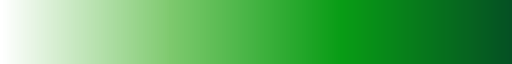

In [278]:
cmp3 = cmaps.WhiteGreen
cmp3

In [ ]:
# figrue s5 model r2
#plot
fig,axs = plt.subplots(4,2,figsize=(9,8),dpi=300,subplot_kw={'projection': ccrs.Robinson()})
#plot cooling effects
plot_columns = ['model4_day', 'model3_day', 'model5_day','model2_day',
                'model4_night', 'model3_night','model5_night', 'model2_night']

for i in range(4):
    ax_i = axs[i,0]
    col_name = plot_columns[i]
    print(col_name)
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    df_all_model_compare.plot(column=col_name, ax=ax_i, cmap=cmp3, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 1,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])

for i in range(4):
    ax_i = axs[i,1]
    col_name = plot_columns[i+4]
    print(col_name)
    ax_i.set_global()
    ax_i.add_feature(cfeature.LAND, facecolor="silver")
    ax_i.set_extent([-180, 180, -60, 90])
    df_all_model_compare.plot(column=col_name, ax=ax_i, cmap=cmp3, legend=False,
                 edgecolor='dimgray', linewidth=0.1, alpha = 0.5, markersize = 1,
                 legend_kwds={'fancybox':False},transform=ccrs.PlateCarree())
    ax_i.spines['top'].set_visible(False)
    ax_i.spines['right'].set_visible(False)
    ax_i.spines['bottom'].set_visible(False)
    ax_i.spines['left'].set_visible(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])


axs[0,0].set_title('Day', loc='center', fontsize=12)
axs[0,1].set_title('Night', loc='center', fontsize=12)

axs[0,0].set_ylabel('Model\n(Vegetation Cover)',fontsize=12,rotation=90,labelpad=10)
axs[1,0].set_ylabel('Model\n(Tree Cover)',fontsize=12,rotation=90,labelpad=10)
axs[2,0].set_ylabel('Model\n(NDVI)',fontsize=12,rotation=90,labelpad=10)
axs[3,0].set_ylabel('Model\n(albedo)',fontsize=12,rotation=90,labelpad=10)

norm = mpl.colors.Normalize(vmin=0, 
                            vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmp3, norm=norm)
sm.set_array([])

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#set ticks
cbar.set_ticks(ticks=[0,1])
#set title
cbar.set_label('Model ${R^2}$',fontsize=12)

#add labels
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top', ha='center')


plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.savefig('./Figs/figs5.png', dpi=300, bbox_inches='tight')
plt.savefig('./Figs/figs5.pdf', dpi=300, bbox_inches='tight')
# plt.close()